# Computing the LCOE of a disruptive tokamak power plant

Based on "the impact of disruptions on the economics of a tokamak power plant" (Maris et al., 2023)

Author: A. D. Maris

Created: 12/9/2022

Updated: 1/30/2023

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from dataclasses import dataclass
from typing import Sequence, Callable
import copy


def scan_2d(x_scan: Sequence[float], y_scan: Sequence[float], f: Callable[[float, float], float]):
    """ Helper function to perform a 2D scan.

    Args:
        x_scan (Sequence[float]): x values to scan.
        y_scan (Sequence[float]): y values to scan.
        f (Callable[[float, float], float]): function f(x, y) to be scanned across x + y.

    Returns:
        (xmesh, ymesh, out): xmesh, ymesh are the meshgrid of x + y values, out is the output of f(x, y) on the meshgrid.
    """
    vf = np.vectorize(f)
    xmesh, ymesh = np.meshgrid(x_scan, y_scan)
    out = vf(xmesh, ymesh)
    return xmesh, ymesh, out

# Section IV.B: Reduced electricity production from accumulated damage

As discussed in the paper, disruptions decrease electricity production by reducing plant lifetime. In this analysis, we will assume disruption rates are constant in time. Failure rates in most industrial applications typically follow one of four trends over time: flat, increasing, decreasing, or "bathtub-shaped" (i.e. relatively high failure rates early and late in life). For a TPP, machine aging could cause disruption rates to increase over time, but more operator experience could counteract this effect. Until we have empirical evidence from running a TPP, it is unclear what the trend will be in practice. For simplicity and tractability, we will neglect a time dependence on the disruption rates in this study.

The irreplaceable components on a TPP (for example, TF magnets) can be thought of as having an "acceptable damage budget." We can write the proportion of the damage budget that is consumed per unit time of operation as
$$ \label{eq:acc_dam_time}
     \tau^{-1}_{\textrm{damage}} \equiv \sum_{i\in \mathcal{C}} p_i \langle d_i \rangle
$$
where $p_i$ is the probability of disruption per time for disruption class $i$ in the set of disruption classes $\mathcal{C}$ and $\langle d_i \rangle \in [0,1]$ is the average damage per disruption as a proportion of the acceptable damage budget in class $i$. For example, a class G disruption that renders the device inoperable would correspond to $\langle d_i \rangle = 1$. We refer to $\tau_{\textrm{damage}}$ as the "characteristic damage time."

For a population of $N$ TPPs, the number that are lost due to damage per unit time $dt$ is approximately 
$$
    dN = -N \tau^{-1}_{\textrm{damage}} dt,
$$
from which we recognize that population decays exponentially. The probability that a particular TPP  does not complete its target operational lifetime of $T$ is:
$$
    P_{\textrm{damage}}(T)  = 1 - \exp{\bigg (-\frac{T}{\tau_{\textrm{damage}}} \bigg )}.
$$
We plot $T=20$ years of operation considering only one disruption class with disruption rate $p$ with an average damage per disruption $\langle d \rangle$ for simplicity.

In [90]:
#Fuction to compute P_damage
def get_P_damage(T,p,d):
    return 1-np.exp(-T*(p*d))

#### Fixed parameter(s)
T=20 #[yr] planned operational lifetime

#### Parameter range to scan
#Disruption rate range to scan.
p_scan = np.logspace(np.log10(10**-2),np.log10(10**2),50) #[year^-1]

#Average damage per disruption as a proportion of damage budget
d_scan = np.logspace(np.log10(10**-5),np.log10(10**-1),40)

p_damage_scan_function = lambda p, d: get_P_damage(T,p,d)
pmesh, dmesh, P_damage = scan_2d(p_scan, d_scan, p_damage_scan_function)

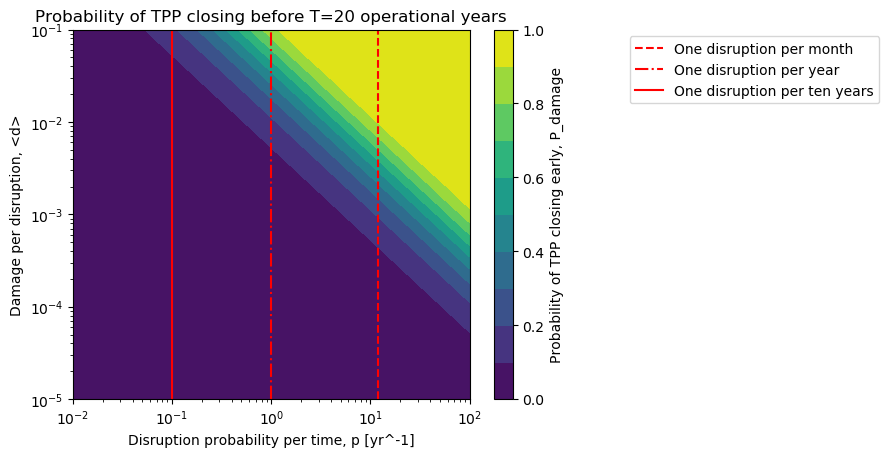

In [91]:
#Create contour plot and color bar
plt.contourf(pmesh,dmesh,P_damage,levels=np.linspace(0,1,11),vmin=0,vmax=1)
cbr= plt.colorbar()

#Include lines showing one disruption per month, etc.
plt.plot([(12),(12)],[d_scan.min(),d_scan.max()],color='red',linestyle='--',label='One disruption per month')
plt.plot([(1),(1)],[d_scan.min(),d_scan.max()],color='red',linestyle='-.',label='One disruption per year')
plt.plot([1/10,1/10],[d_scan.min(),d_scan.max()],color='red',linestyle='-',label='One disruption per ten years')
plt.legend(bbox_to_anchor=(2.05, 1.0))

#Add a labels, adjust scales
plt.title('Probability of TPP closing before T=20 operational years')
cbr.set_label('Probability of TPP closing early, P_damage')
plt.ylabel('Damage per disruption, <d>')
plt.xlabel('Disruption probability per time, p [yr^-1]')
plt.yscale('log')
plt.xscale('log')
# plt.savefig('Plots/damage.png',dpi=200,bbox_inches='tight')

In [92]:
# #Save data from plot
# np.save('Data/p_scan.npy', p_scan)
# np.save('Data/d_scan.npy', d_scan)
# np.save('Data/P_damage.npy', P_damage)

We can compute a maximum allowable disruption rate $p$ given the utility's maximum allowable probability of an early plant closure due to damage $P_{\textrm{damage,max}} \ll 1$.

In [93]:
#Function to compute maximum allowable disruption rate
def get_p_damage(T,P_damage_max,d):
    return np.log(1/P_damage_max)/(T*d)

Consider a plant with a power producing lifetime of 20 years, a utility that tolerates $P_{\textrm{damage,max}}=0.25$, and assume that we can simplify the situation to consider only a single class of disruption that causes accumulated damage of $\langle d \rangle = 0.01$. 

In [94]:
p_example = get_p_damage(T,0.25,0.01)
print(f'In this case, the maximum allowable disruption rate is {p_example:.2f} [yr^-1]')

In this case, the maximum allowable disruption rate is 6.93 [yr^-1]


We scan over a range of $P_{\textrm{damage,max}}$ and $\langle d \rangle$ to create a plot:

In [95]:
#### Parameter range to scan
# Range of utility's maximum allowable probability of an early plant closure due to damage
P_damage_max_scan = np.logspace(np.log10(10**-0.3),np.log10(10**-2),50)
#Average damage per disruption as a proportion of damage budget
d_scan = np.logspace(np.log10(10**-5),np.log10(10**-1),40)

#Compute p
p_req_scan_function = lambda P_damage_max, d: get_p_damage(T,P_damage_max, d)
P_damage_mesh, d_mesh, p_req = scan_2d(P_damage_max_scan, d_scan, p_req_scan_function)

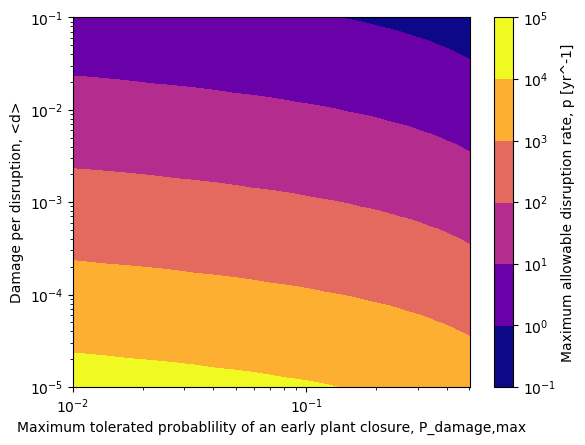

In [96]:
#Create contour plot and color bar
plt.contourf(P_damage_max_scan,d_scan,p_req,norm=colors.LogNorm(vmin=p_req.min(), vmax=p_req.max()),cmap='plasma')
cbr= plt.colorbar()

#Add a labels, adjust scales
cbr.set_label('Maximum allowable disruption rate, p [yr^-1]')
plt.ylabel('Damage per disruption, <d>')
plt.xlabel('Maximum tolerated probablility of an early plant closure, P_damage,max')
plt.yscale('log')
plt.xscale('log')
#plt.savefig('Plots/damage_disrupt_rate_limit.png',dpi=200)

In [97]:
# #Save data from plot
# np.save('Data/P_damage_max_scan.npy', P_damage_max_scan)
# np.save('Data/p_req.npy', p_req)

### IV.C Reduced electricity production because of outage

Utilities will expect a TPP to have relatively little operational time interrupted by a disruption-induced outage. This is consistent with TPP costing models which find that a high duty factor is required for economic viability. Given this, we approximate 
$$\textrm{Fraction of operating time lost to recovery} = f_{\textrm{lost}}  \approx
    \sum_{i\in \mathcal{C}} p_i \langle \Delta t_{i,\textrm{recover}} \rangle,$$
where once again $p_i$ is the probability of disruption per time for disruption class $i$ in the set of classes $\mathcal{C}$ and $\langle \Delta t_{i,\textrm{recover}} \rangle$ is the average recovery time from that disruption type.

In [98]:
#Compute f_lost
def get_f(p,deltat):
    return p*deltat


We produce plots of $f_{\textrm{lost}}$ assuming only one type of disruption of disruption with a probabilty of occuring per year $p$ and an average time to recover $\langle \Delta t_{\textrm{recover}} \rangle$

In [99]:
#### Parameter range to scan
# Range of disruption rate values to scan, [year^-1]
p_scan = np.logspace(np.log10(10**-2),np.log10(10**2),50)
# Range of deltat values to scan, [year^-1]
deltat_scan = np.logspace(np.log10(10**-1),np.log10(10**-4),40)

p_mesh, deltat_mesh, f_array = scan_2d(p_scan, deltat_scan, get_f)

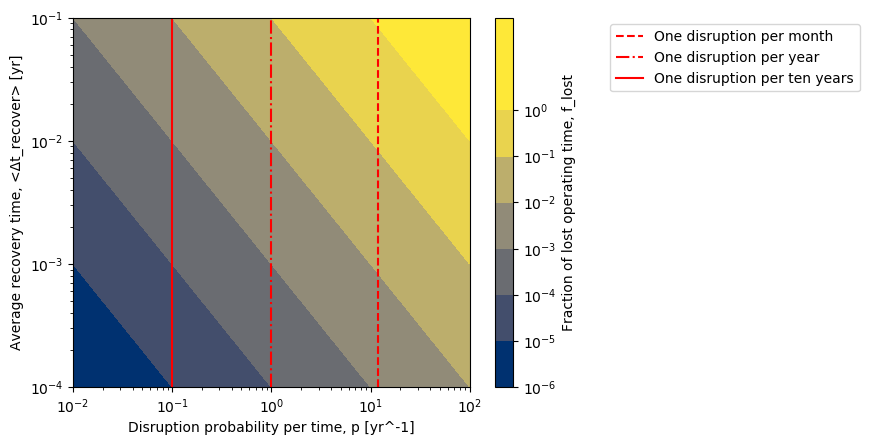

In [100]:
#Create contour plot and color bar
plt.contourf(p_mesh,deltat_mesh,f_array,norm=colors.LogNorm(vmin=f_array.min(), vmax=1),cmap='cividis',vmax=1)
cbr= plt.colorbar(ticks=np.logspace(-6,0,7,endpoint=True))

#Include lines showing one disruption per month, etc.
plt.plot([(12),(12)],[deltat_scan.min(),deltat_scan.max()],color='red',linestyle='--',label='One disruption per month')
plt.plot([(1),(1)],[deltat_scan.min(),deltat_scan.max()],color='red',linestyle='-.',label='One disruption per year')
plt.plot([1/10,1/10],[deltat_scan.min(),deltat_scan.max()],color='red',linestyle='-',label='One disruption per ten years')
plt.legend(bbox_to_anchor=(2, 1.0))

#Add a labels, adjust scales
cbr.set_label('Fraction of lost operating time, f_lost')
plt.ylabel('Average recovery time, <Δt_recover> [yr]')
plt.xlabel('Disruption probability per time, p [yr^-1]')
plt.yscale('log')
plt.xscale('log')
#plt.savefig('Plots/lost_time.png',dpi=200,bbox_inches='tight')

In [101]:
# #Save data from plot
# np.save('Data/deltat_scan.npy', deltat_scan)
# np.save('Data/f_array.npy', f_array)

Requiring that the fraction of lost operating time is relatively small can be stated as
$$
    f_{\textrm{lost}}  < f_{\textrm{lost,max}} \ll 1,
$$
where $f_{\textrm{lost,max}}$ represents that maximum fraction of operating time that a utility can tolerate due to disruption recovery. For example, if we consider only class $E$ disruptions with an average of two months of recovery time for a given TPP, and take $f_{\textrm{lost,max}} = 0.25$, then this leads to the required disruption rate of

In [102]:
#Function to compute maximum allowable disruption rate
def get_p_lost(f_lost_max,deltat):
    return f_lost_max/(deltat)

p_example_lost = get_p_lost(0.25,1/6)
print(f'In this case, the maximum allowable disruption rate is {p_example_lost:.2f} [yr^-1]')

In this case, the maximum allowable disruption rate is 1.50 [yr^-1]


We plot the maximum allowable disruption rate for a range of $f_{\textrm{lost,max}}$ and $\langle \Delta t_{\textrm{recover}} \rangle$. Recall that disruptions rates for high performances plasmas are typically on the order of $p \gtrapprox 1 \textrm{ min}^{-1} \approx 5 \cdot 10^{5} \textrm{ yr}^{-1}$ for comparison.

In [103]:
#### Parameter range to scan
#Maximum fraction of operating time that a utility can tolerate due to disruption recovery
f_lost_max_upper =10**-0.5 #Maximum f_lost_max to scan
f_lost_max_lower =10**-2 #Minimum f_lost_max to scan


#Create scan matrices
f_lost_max_scan = np.logspace(np.log10(f_lost_max_lower),np.log10(f_lost_max_upper),50)

#Compute p
f_lost_max_mesh, deltat_mesh, p_req_lost =  scan_2d(f_lost_max_scan, deltat_scan, get_p_lost)

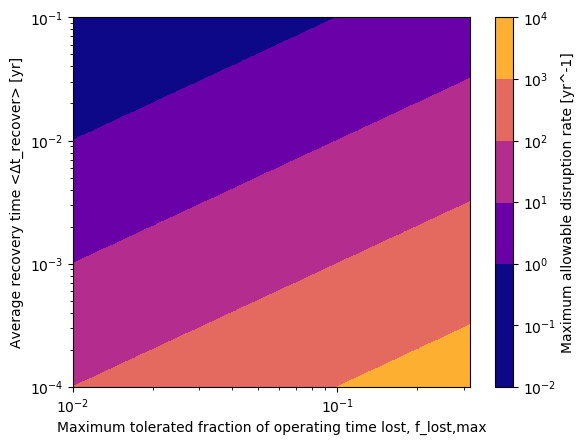

In [104]:
#Create contour plot and color bar
plt.contourf(f_lost_max_mesh,deltat_mesh,p_req_lost,norm=colors.LogNorm(vmin=p_req.min(), vmax=p_req.max()),cmap='plasma')
cbr= plt.colorbar()

#Add a labels, adjust scales
cbr.set_label('Maximum allowable disruption rate [yr^-1]')
plt.ylabel('Average recovery time <Δt_recover> [yr]')
plt.xlabel('Maximum tolerated fraction of operating time lost, f_lost,max')
plt.yscale('log')
plt.xscale('log')
#plt.savefig('Plots/lost_time_disrupt_rate_limit.png',dpi=200)

In [105]:
# #Save data from plot
# np.save('Data/f_lost_max_scan.npy', f_lost_max_scan)
# np.save('Data/p_req_lost.npy', p_req_lost)

# IV.E Disruption-aware LCOE

Gathering the arguments from earlier in this section, we can show how disruptions affect the LCOE of a TPP. We consider the case of a tokamak which experiences low expected time lost for disruption recovery ($ f_{\textrm{lost}} \ll 1$). In terms of the annual costs ($I_t,M_t,F_t$), duty factor $f_{\textrm{duty}}$, and electrical energy production ($E_t$) of a hypothetical tokamak with no disruptions, then the LCOE of a TPP with disruptions can be written as
$$
    \textrm{LCOE}_{\textrm{dis}} \approx \\ \frac{\sum^{n}_{t=1} (\boldsymbol{k_{I,t}}I_t + \boldsymbol{k_{M,t}}M_t + F_t)(1+r)^{-t}}{ \sum^{n}_{t=1}  E_t(1+r)^{-t}  \boldsymbol{(f_{\textrm{margin},t})}  \boldsymbol{ (1 - f_{\textrm{lost}})}   \boldsymbol{(1-P_{\textrm{damage}}(t f_{\textrm{duty}}))}} 
$$
where the new terms have been emphasized in bold. The only costs not affected by disruptions are the fuel costs, which are negligible relative to the capital and O\&M costs of a TPP.

We show how this methodology can be utilized in practice for an example ARC-like TPP case. The baseline characteristics of the example without disruptions are shown below. We assume constant capital cost during the construction phase and constant O\&M and fuel costs. The LCOE as a function of various parameters is shown in the below plots

In [106]:
@dataclass
class DLCOEData:
    P_elect: float #[MW] Electrical power
    I: float #[USD] Annual capital cost during construction.
    M: float #[USD] Annual O&M cost 
    F: float #[USD] Annual fuel cost 
    P_elect: float #[MW] Electrical power
    duty_factor: float #[-] Duty factor
    r: float # [-] Interest rate
    n_op: int #[yr] Number of years in operation
    n_construct: int #[yr] Number of years under construction.
    kI: float = 1.0
    kM: float = 1.0
    f_margin: float = 1.0
    pdeltat: float = 0.0
    tau: float = np.inf

    @property
    def E(self):
        """[MWh] Annual energy produced"""
        h_per_yr = 365 * 24 #[h/yr] Conversion factor of h to yr
        return self.P_elect*self.duty_factor*h_per_yr
    

#Planned operation and construction time
n_construct = 5 #[yr] Number of years of construction
n_op = 20 #[yr] Number of years in operation
default_data = DLCOEData(P_elect=500,       # Assume a 500 MWe plant.
                         I=2e9/n_construct, # Assume the plants total cost is 2 billion dollars.
                         M=0.5*2e9/n_op,    # Assume the plants total O&M cost is half of the construction cost.
                         F=0.05*2e9/n_op,   # Assume the plants total fuel cost is 5% of the construction cost.
                         duty_factor=0.8,   # Assume an 80% duty factor.
                         r=0.07,            # Assume a 7% interest rate.
                         n_op=n_op,           # Assume the plant will operate for 20 years.
                         n_construct=n_construct)     # Assume the plant will be under construction for 5 years.

In [107]:
def get_LCOE_disrupt(data: DLCOEData):
    #We will sum up the numerator and denominator of the LCOE separately, and divide at the end
    n_tot=data.n_construct+data.n_op
    numerator=0
    denominator = 0
    #Over all years from the beginning of construction to retirement
    for t in range(n_tot):
        
        #If during construction
        if t<n_construct:
            numerator += data.kI*data.I*(1+data.r)**(-t) #Add construction costs
        
        #Else during operation lifetime
        else:
            numerator += data.kM*data.M*(1+data.r)**(-t)
            denominator += (1-data.pdeltat)*data.f_margin*data.E*(1+data.r)**(-t)*(np.exp(-t/data.tau*data.duty_factor))
    
    #Return LCOE
    return numerator/denominator

First, we compute the LCOE of the baseline no disruption case

In [108]:
LCOE_baseline=get_LCOE_disrupt(default_data)
print(f'The LCOE of the baseline, no disruption case is {LCOE_baseline:.2f} [$/MWh]')

The LCOE of the baseline, no disruption case is 76.24 [$/MWh]


## LCOE($k_I$,$k_M$)
All other values set to baseline no disruption case

In [109]:
#### Parameter range to scan
#Capital cost scaling factor
kI_upper =3 #Maximum to scan
kI_lower =1 #Minimum to scan
#O&M cost scaling factor
kM_upper =3 #Maximum to scan
kM_lower =1 #Minimum to scan

#Create scan matrices
kI_scan=np.linspace(kI_lower,kI_upper,40)
kM_scan=np.linspace(kM_lower,kM_upper,40)

#Compute LCOE
def scanner_kI_kM(kI, kM):
    data = copy.copy(default_data)
    data.kI = kI
    data.kM = kM
    return get_LCOE_disrupt(data)
kI_mesh, kM_mesh, LCOE_k = scan_2d(kI_scan, kM_scan, scanner_kI_kM)

Text(0.5, 0, 'k_M')

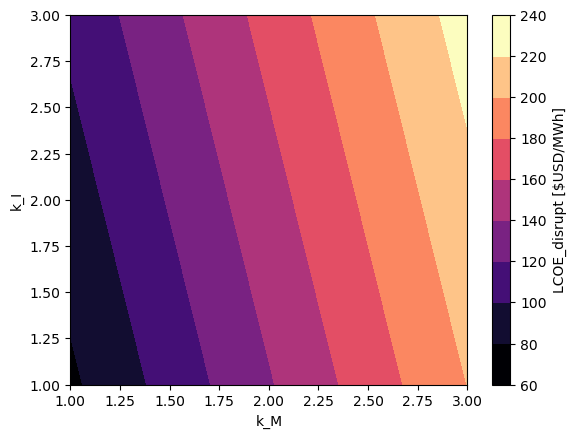

In [110]:
#Create contour plot and color bar
cs=plt.contourf(kI_mesh,kM_mesh,LCOE_k,cmap='magma',norm=colors.Normalize(vmin=LCOE_k.min(), vmax=LCOE_k.max()))
cbr= plt.colorbar()

#Add a labels, adjust scales
cbr.set_label('LCOE_disrupt [$USD/MWh]')
plt.ylabel('k_I')
plt.xlabel('k_M')

In [111]:
# #Save data from plot
# np.save('Data/kI_scan.npy', kI_scan)
# np.save('Data/kM_scan.npy', kM_scan)
# np.save('Data/LCOE_k.npy', LCOE_k)

## LCOE($f_{\textrm{lost}}$,$f_{\textrm{margin}}$)
All other values set to baseline no disruption case

In [112]:
#### Parameter range to scan
#Fraction of target electrical power produced to keep sufficient margin to disruptive instabilities
fmargin_upper = 10**0 #Maximum to scan
fmargin_lower = 10**-0.3 #Minimum to scan
#Fraction of operating time lost to disruption recovery 
pdeltat_upper = 10**-0.3 #Maximum to scan
pdeltat_lower = 10**-2 #Minimum to scan

#Create scan matrices
fmargin_scan=np.logspace(np.log10(fmargin_lower),np.log10(fmargin_upper),80)
pdeltat_scan=np.logspace(np.log10(pdeltat_lower),np.log10(pdeltat_upper),80)

def scanner_f_pdeltat(fmargin, pdeltat):
    data = copy.copy(default_data)
    data.f_margin = fmargin
    data.pdeltat = pdeltat
    return get_LCOE_disrupt(data)

#Compute LCOE
fmargin_mesh, pdeltat_mesh, LCOE_f = scan_2d(fmargin_scan, pdeltat_scan, scanner_f_pdeltat)

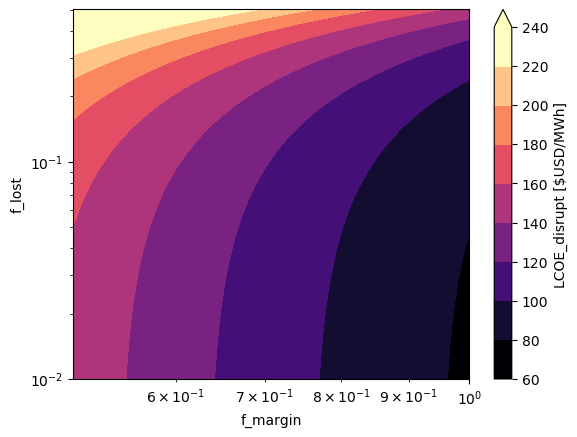

In [113]:
#Create contour plot and color bar
ax=plt.contourf(fmargin_mesh,pdeltat_mesh,LCOE_f,cmap='magma',norm=colors.Normalize(vmin=LCOE_k.min(), vmax=LCOE_k.max()),levels=cs.levels,extend='max')
cbr= plt.colorbar()

#Add a labels, adjust scales
cbr.set_label('LCOE_disrupt [$USD/MWh]')
plt.ylabel('f_lost')
plt.xlabel('f_margin')
plt.yscale('log')
plt.xscale('log')

In [114]:
# #Save data from plot
# np.save('Data/fmargin_scan.npy', fmargin_scan)
# np.save('Data/pdeltat_scan.npy', pdeltat_scan)
# np.save('Data/LCOE_f.npy', LCOE_f)

## LCOE($n_{\textrm{lifetime}}$,$\tau_{\textrm{damage}}$)
All other values set to baseline no disruption case

In [115]:
#### Parameter range to scan
#Characteristic damage time
tau_upper = 10**2 #Maximum to scan [yr]
tau_lower = 10**1 #Minimum to scan [yr]
#Lifetime of plant
T_upper = 50 #Maximum to scan [yr]
T_lower = 10 #Minimum to scan [yr]

#Create scan matrices
tau_scan=np.logspace(np.log10(tau_lower),np.log10(tau_upper),80)
n_op_scan=np.arange(T_lower,T_upper,1)

def scanner_tau_nop(n_op, tau):
    data = copy.copy(default_data)
    data.tau = tau
    data.n_op = n_op
    return get_LCOE_disrupt(data)

#Compute LCOE
n_op_mesh, tau_mesh, LCOE_tau = scan_2d(n_op_scan, tau_scan, scanner_tau_nop)

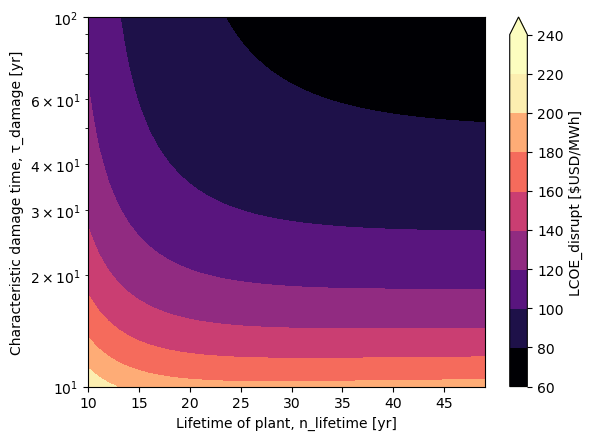

In [116]:
#Create contour plot and color bar
plt.contourf(n_op_mesh,tau_mesh,LCOE_tau,cmap='magma',norm=colors.Normalize(vmin=LCOE_tau.min(), vmax=LCOE_tau.max()),levels=cs.levels,extend='max')
cbr= plt.colorbar()

#Add a labels, adjust scales
cbr.set_label('LCOE_disrupt [$USD/MWh]')
plt.ylabel('Characteristic damage time, τ_damage [yr]')
plt.xlabel('Lifetime of plant, n_lifetime [yr]')
plt.yscale('log')


In [117]:
# #Save data from plot
# np.save('Data/T_scan.npy', T_scan)
# np.save('Data/tau_scan.npy', tau_scan)
# np.save('Data/LCOE_tau.npy', LCOE_tau)

## Example of \\$100 per MWh tokamak power plant with disruptions 

Note that for each of these plots we hold everything to the baseline values except for what is plotted. To fully account for disruptions, one must consider the effect of all the disruption-related parameters together. For example, one design that reaches the \\$100/MWh target has $k_I = 1.5,\: k_M=1.25,\: f_{\textrm{lost}} = 0.03,\: f_{\textrm{margin}} = 0.99,\: \tau_{\textrm{damage}} = 200 \textrm{ yr},\textrm{ and } n_{\textrm{lifetime}}= 50 \textrm{ yr}$.

In [118]:
#Planned operation and construction time
n_construct = 5 #[yr] Number of years of construction
n_op = 50 #[yr] Number of years in operation

default_data = DLCOEData(P_elect=500,       # Assume a 500 MWe plant.
                         I=2e9/n_construct, # Assume the plants total cost is 2 billion dollars.
                         M=0.5*2e9/n_op,    # Assume the plants total O&M cost is half of the construction cost.
                         F=0.05*2e9/n_op,   # Assume the plants total fuel cost is 5% of the construction cost.
                         duty_factor=0.8,   # Assume an 80% duty factor.
                         r=0.07,            # Assume a 7% interest rate.
                         n_op=n_op,           # Assume the plant will operate for 20 years.
                         n_construct=n_construct, # Assume the plant will be under construction for 5 years.
                         kI=1.5,
                         kM=1.25,
                         f_margin=0.99,
                         pdeltat=0.03,
                         tau=200)

LCOE_example=get_LCOE_disrupt(default_data)
print(f'The LCOE of the this case is {LCOE_example:.2f} [$/MWh]')

The LCOE of the this case is 87.58 [$/MWh]
